In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load all files in ./mediciones directory
mediciones = os.listdir('./mediciones')
files_pesos = [f for f in mediciones if f.startswith('peso')]
files_pesos.sort()

# Load all files
dfs_pesos = []
df = pd.DataFrame(columns=['M', 'L'])

for f in files_pesos:
    peso = pd.read_csv(f'./mediciones/{f}', sep=',', header=0, nrows=0).columns[1]
    distancia = pd.read_csv(f'./mediciones/{f}', sep=',', header=1, nrows=0).columns[1]
    temp_df = pd.DataFrame({'M': float(peso)/1000,
                                 'L': float(distancia)/1000}, index=[0])
    df = pd.concat([df, temp_df], ignore_index=True)

    dfs_pesos.append(pd.read_csv(f'./mediciones/{f}', sep=',', header=2))

In [2]:
df

,M,L
0,0.17486,0.367
1,0.26979,0.402
2,0.27258,0.403
3,0.32518,0.418
4,0.37068,0.434
5,0.42011,0.455
6,0.51783,0.487
7,0.61573,0.518
8,0.71865,0.552


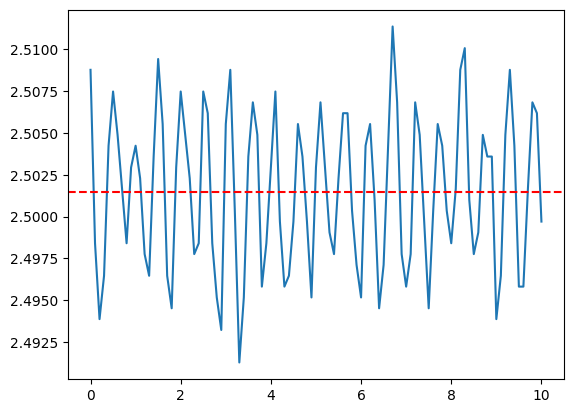

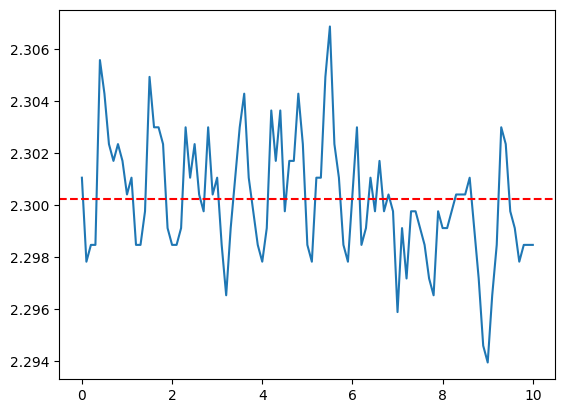

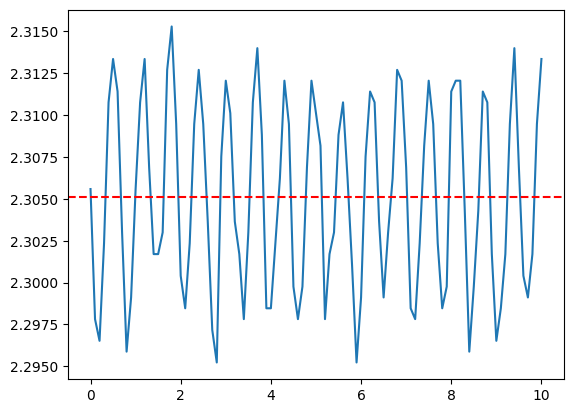

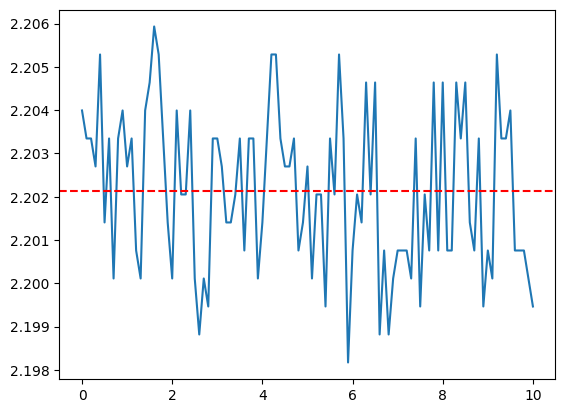

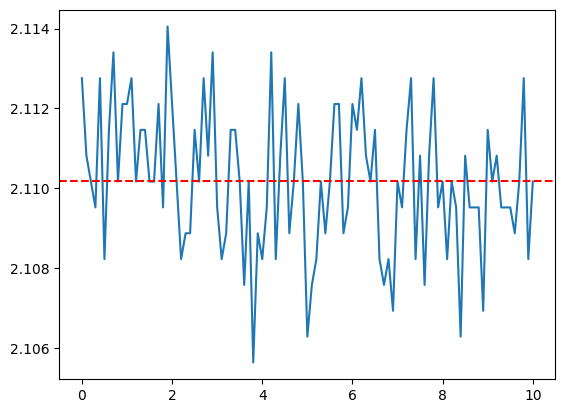

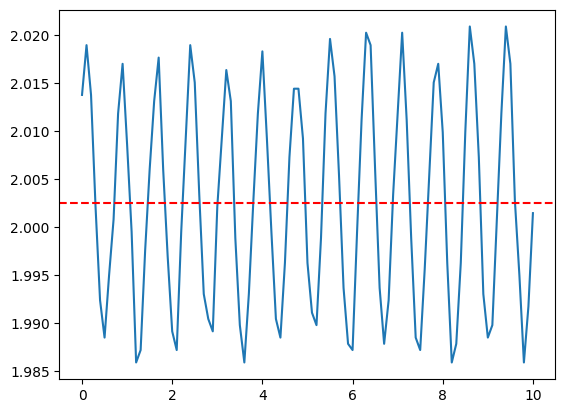

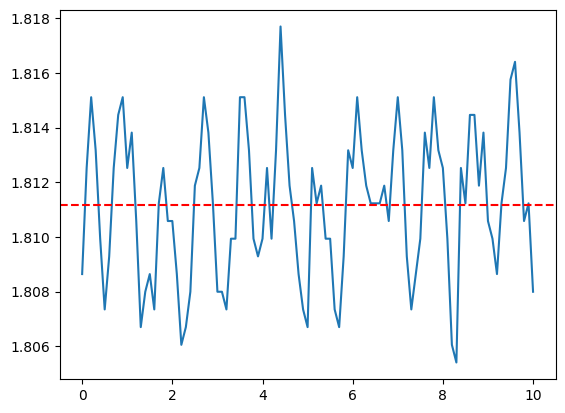

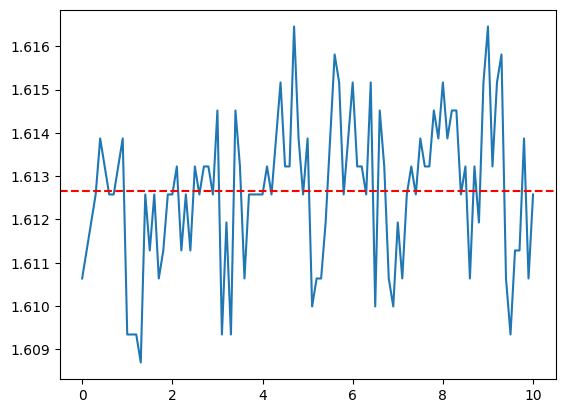

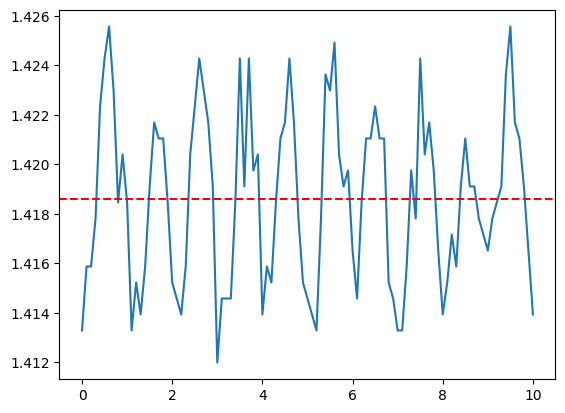

In [3]:
for df_peso in dfs_pesos:
    plt.plot(df_peso['time'], df_peso['(N)'])
    # add mean value
    plt.axhline(y=df_peso['(N)'].mean(), color='r', linestyle='--')
    plt.show()

In [4]:
# 1 A
# medimos la longitud natural del resorte, si esta horizontal nos da 307 mm y si esta en vertical nos da 310 mm
# Como nos interesa saber x_eq - l_0, vamos realizar estadistica para calcular L = x_eq - l_0

l_0 = 0.310
dl_0 = 0.001
dL = 0.001

df.loc[:, 'L'] = df['L'] - l_0

# Anotamos el error en la medida del resorte
df.loc[:, "dL"] = np.sqrt(dl_0**2 + dL**2)
df

,M,L,dL
0,0.17486,0.057,0.001414
1,0.26979,0.092,0.001414
2,0.27258,0.093,0.001414
3,0.32518,0.108,0.001414
4,0.37068,0.124,0.001414
5,0.42011,0.145,0.001414
6,0.51783,0.177,0.001414
7,0.61573,0.208,0.001414
8,0.71865,0.242,0.001414


In [5]:
# Calculamos dM, como M es la medida indirecta de la suma de todos los pesos, entonces hay hacer propagacion de errores. este mismo ejemplo estan en el apunte
#http://materias.df.uba.ar/f1qa2021v/files/2020/03/Clase-5-Mediciones-Indirectas.pdf pagina 15

# el error instrumental seria sqrt(numero de pesos) * 0.00001 (error de inst de balanza), como no hicimos varios pesajes el error estadistico es 0

df.loc[:, "dM"] = np.sqrt(np.array([1,2,2,2,3,3,4,5,6])) * 0.00001
df = df[['M', 'dM', 'L', 'dL']]
df

,M,dM,L,dL
0,0.17486,0.000010,0.057,0.001414
1,0.26979,0.000014,0.092,0.001414
2,0.27258,0.000014,0.093,0.001414
3,0.32518,0.000014,0.108,0.001414
4,0.37068,0.000017,0.124,0.001414
5,0.42011,0.000017,0.145,0.001414
6,0.51783,0.000020,0.177,0.001414
7,0.61573,0.000022,0.208,0.001414
8,0.71865,0.000024,0.242,0.001414


In [6]:
# haciendo estadistica ya que tenemos muchas mediciones de V en el tiempo nos queda que

df.loc[:, 'V'] = np.nan
df.loc[:, 'dV'] = np.nan

for i, peso in enumerate(dfs_pesos):
    n_samples = len(peso)
    V = peso['(N)'].mean()

    # TODO asumo dV instrmental como 0.01 pero hay que hacer la medida en origin, hay que hacer mucho zoom y ver los saltos entre los voltajes
    dV = np.sqrt((peso['(N)'].std() / np.sqrt(n_samples))**2 + 0.01**2)
    #df['V'].iloc[i] = V
    #df['dV'].iloc[i] = dV
    df.loc[i, 'V'] = V
    df.loc[i, 'dV'] = dV

df

/home/jack/miniconda3/envs/ray113/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/jack/miniconda3/envs/ray113/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,M,dM,L,dL,V,dV
0,0.17486,0.000010,0.057,0.001414,2.501489,0.010011
1,0.26979,0.000014,0.092,0.001414,2.300220,0.010003
2,0.27258,0.000014,0.093,0.001414,2.305115,0.010016
3,0.32518,0.000014,0.108,0.001414,2.202142,0.010002
4,0.37068,0.000017,0.124,0.001414,2.110176,0.010002
5,0.42011,0.000017,0.145,0.001414,2.002475,0.010060
6,0.51783,0.000020,0.177,0.001414,1.811149,0.010004
7,0.61573,0.000022,0.208,0.001414,1.612655,0.010001
8,0.71865,0.000024,0.242,0.001414,1.418619,0.010006


In [7]:
def error_relativo(dX, X):
    return dX / X

def mayorErrorRelativo(df, col1, dcol1, col2, dcol2):
    res = []
    erroresRelativos1 = []
    erroresRelativos2 = []

    for index, row in df.iterrows():
        errorRelativoM = error_relativo(row[dcol1], row[col1])
        errorRelativow = error_relativo(row[dcol2], row[col2])

        if errorRelativoM > errorRelativow:
            res.append(col1)
        else:
            res.append(col2)

        erroresRelativos1.append(errorRelativoM)
        erroresRelativos2.append(errorRelativow)

    return (res, erroresRelativos1, erroresRelativos2)

res, erroresRelativosM, erroresRelativosL = mayorErrorRelativo(df, 'M', "dM", "L", 'dL')

print(erroresRelativosM)

print(erroresRelativosL)

print(res)

[5.7188608029280565e-05, 5.241905046047278e-05, 5.188251384448952e-05, 4.3490176590598906e-05, 4.672630861036143e-05, 4.122850699980665e-05, 3.8622714018114054e-05, 3.631572243515486e-05, 3.408459949604367e-05]
[0.024810764252159563, 0.015371886547533638, 0.015206597444871985, 0.013094570021973104, 0.011404948083653992, 0.009753196981883414, 0.007989907132051385, 0.006799103665255264, 0.0058438576957565895]
['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


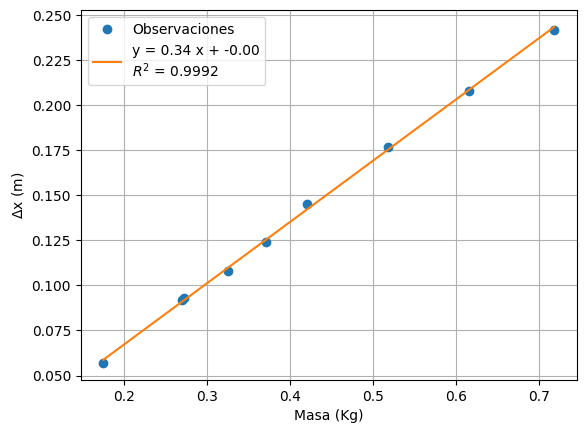

Valor de K = 28.883011878503865 +- 0.23962046704837386


In [8]:
# 2C
def lineal(x, a, b):
    return a * x + b

def fit_with_curve(lineal, x, y, y_err):
    popt, pconv = curve_fit(lineal, x, y, sigma=y_err, absolute_sigma=True)
    return popt[0], popt[1], np.sqrt(pconv.diagonal())[0], np.sqrt(pconv.diagonal())[1]

a, b, da, db = fit_with_curve(lineal, df['M'], df['L'], df['dL'])

R2 = 1 - np.sum((lineal(df['M'], a, b) - df['L'])**2) / np.sum((df['L'] - np.mean(df['L']))**2)

#plt.errorbar(df['M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['M'], df['L'], 'o', label='Observaciones')

plt.plot(df['M'], lineal(df['M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel("Masa (Kg)")
plt.ylabel(r'$\Delta$x (m)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
# TODO si quieren ponemos g de la notebook anterior
g = 9.81
K = g/a
dK = g/a**2 * da
print(f"Valor de K = {K} +- {dK}")

In [9]:

# Si bien para este experiment con M y L ya podriamos calcular K, vamos a hacer una regresion lineal para calclar k_0 y k_1 ya que nos sera de utilidad
# en la parte 2 del tp (medicion dinamina)
# para calcular k_0 y k_1, hay que hacer regrecion lineal para traducir de Voltaje(V) a  Masa (g)
# entonces m = k_1 * V + k_0
# dm = k_1 * dV 

In [10]:
files_periodos = [f for f in mediciones if f.startswith('periodo')]
files_periodos.sort()

# Load all files
dfs_periodos = []
pesos = []
for f in files_periodos:
    peso = pd.read_csv(f'./mediciones/{f}', sep=',', header=0, nrows=1).columns[1]
    pesos.append(float(peso)/1000)
    df = pd.read_csv(f'./mediciones/{f}', sep=',', header=1)
    dfs_periodos.append(df)


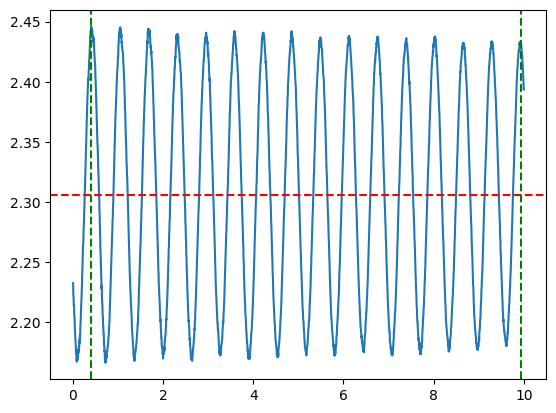

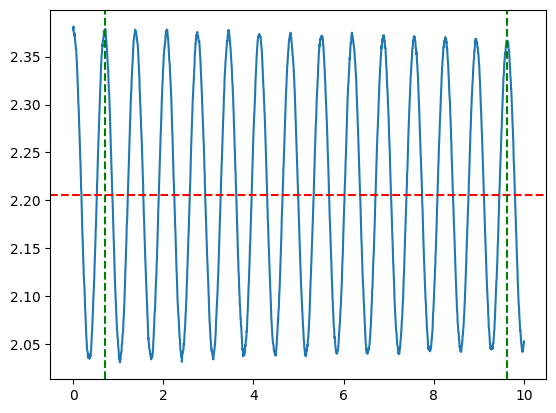

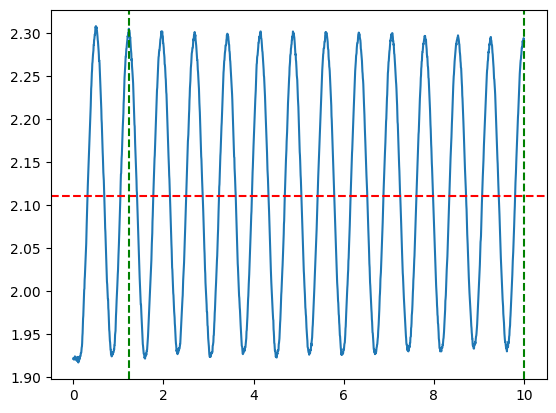

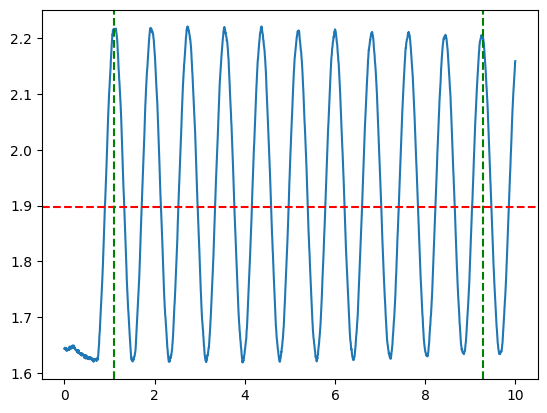

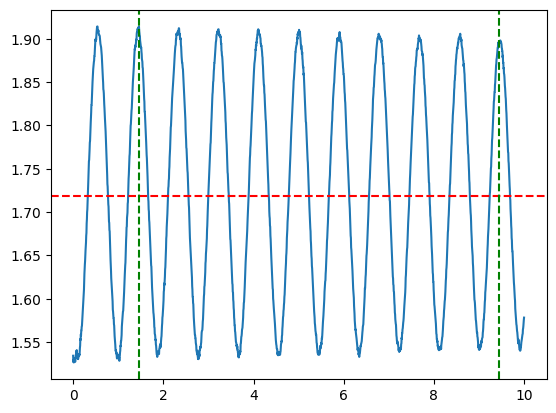

In [11]:
# 1 A
# hay que calcular el prime y ultimo pico y hacer su resta y despues dividir por la #ciclos que es #picos - 1
# para eso primero calculamos los picos del borde y los guardamos

local_maximas_index = []

def find_first_local_maxima(arr):
    rad = 3
    for i in range(rad, len(arr) - rad):
        if arr[i] > arr.mean() and arr[i] > max(arr[i - rad:i]) and arr[i] > max(arr[i + 1:i + rad + 1]):
            return i
    return None

def find_last_local_maxima(arr):
    rad = 3
    for i in range(len(arr) - 2, 0, -1):
        if arr[i] > arr.mean() and arr[i] > max(arr[i - rad:i]) and arr[i] > max(arr[i + 1:i + rad + 1]):
            return i
    return None

for df in dfs_periodos:
    plt.plot(df['time'], df['(N)'])
    plt.axhline(y=df['(N)'].mean(), color='r', linestyle='--')

    arr = df['(N)']
    local_maxima_indices = [find_first_local_maxima(arr), find_last_local_maxima(arr)]
    local_maximas_index.append((find_first_local_maxima(arr), find_last_local_maxima(arr)))
    for i in local_maxima_indices:
        plt.axvline(x=dfs_periodos[0]['time'][i], color='g', linestyle='--')
    plt.show()


In [12]:
# calculamos el tiempo entre los picos graficados: restamos los indices de los picos y multiplicamos por 0.005 que es 1/f y para obtener el tiempo
# luego calculamos el periodo dividiendo por el #ciclos = #picos - 1

periods = []
local_maximas_cicles = [15,13,12,10,9]

for k in range(len(local_maximas_index)):
    periods.append((local_maximas_index[k][1] - local_maximas_index[k][0]) * 0.005 / local_maximas_cicles[k])

periods

[0.635, 0.6861538461538461, 0.7295833333333334, 0.817, 0.8861111111111112]

In [13]:
# Como T = t_f - t_i / (N-1)
dT = np.sqrt(0.005**2 + 0.005**2)

df = pd.DataFrame()

df['T'] = np.array(periods)
df.loc[:, 'dT'] = dT

df['M'] = np.array(pesos)
df.loc[:, "dM"] = np.sqrt(np.array([2,2,3,4,5])) * 0.00001

df['1_M'] = 1/df['M']
df['d_1_M'] = df['dM'] / df['M']**2

df['1_sqrt_M'] = 1/np.sqrt(df['M'])
df['d_1_sqrt_M'] = df['dM'] / (2 * (df['M'])**(3/2))

df['w'] = 2*np.pi / df['T']
df.loc[:, 'dw'] = 2*np.pi / (df['T']**2) * df['dT']

df['w2'] = df['w']**2
df['dw2'] = 2 * df['w'] * df['dw']

df['1_w2'] = 1/df['w']**2
df['d_1_w2'] = df['dw'] / (2 * df['w']**3)

#df['M w2'] = df['M'] * df['w']**2
#df['d_M w2'] = np.sqrt((df['w']**2 * df['dM'])**2 + (2 * df['w'] * df['M'] * df['dw'])**2)

df

,T,dT,M,dM,1_M,d_1_M,1_sqrt_M,d_1_sqrt_M,w,dw,w2,dw2,1_w2,d_1_w2
0,0.635000,0.007071,0.27276,0.000014,3.666227,0.000190,1.914739,0.000050,9.894780,0.110184,97.906671,2.180487,0.010214,0.000057
1,0.686154,0.007071,0.32518,0.000014,3.075220,0.000134,1.753630,0.000038,9.157109,0.094367,83.852638,1.728265,0.011926,0.000061
2,0.729583,0.007071,0.36768,0.000017,2.719756,0.000128,1.649168,0.000039,8.612019,0.083467,74.166866,1.437640,0.013483,0.000065
3,0.817000,0.007071,0.46540,0.000020,2.148689,0.000092,1.465841,0.000031,7.690557,0.066561,59.144671,1.023785,0.016908,0.000073
4,0.886111,0.007071,0.56033,0.000022,1.784663,0.000071,1.335913,0.000027,7.090742,0.056583,50.278623,0.802436,0.019889,0.000079


In [14]:
res, erroresRelativos1, erroresRelativos2 = mayorErrorRelativo(df, '1_sqrt_M', 'd_1_sqrt_M', 'w', 'dw')
print(erroresRelativos1)
print(erroresRelativos2)
print(res)

[2.592413774697711e-05, 2.1745088295299453e-05, 2.355378056419818e-05, 2.1486892995272885e-05, 1.995313455909723e-05]
[0.011135539861205473, 0.010305367887247889, 0.009691926184167412, 0.008654917762381245, 0.007979888439722794]
['w', 'w', 'w', 'w', 'w']


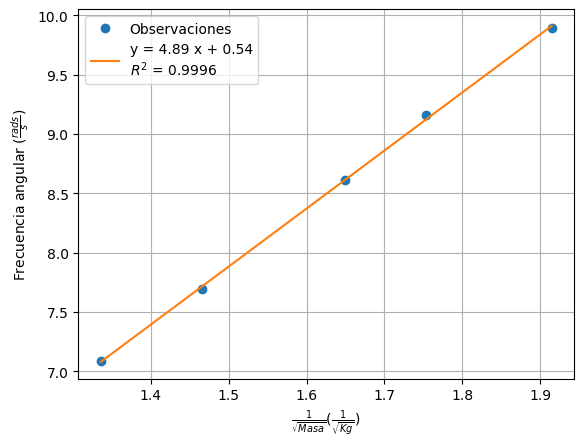

Valor de K = 23.936245554702495 +- 1.715332105682588


In [15]:
# 2C
a, b, da, db = fit_with_curve(lineal, df['1_sqrt_M'], df['w'], df['dw'])

R2 = 1 - np.sum((lineal(df['1_sqrt_M'], a, b) - df['w'])**2) / np.sum((df['w'] - np.mean(df['w']))**2)

#plt.errorbar(df['M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['1_sqrt_M'], df['w'], 'o', label='Observaciones')

plt.plot(df['1_sqrt_M'], lineal(df['1_sqrt_M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(r'$\frac{1}{\sqrt{Masa}} (\frac{1}{\sqrt{Kg}})$')
plt.ylabel(r'Frecuencia angular ($\frac{rads}{s}$)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
K = a**2
dK = 2*a * da
print(f"Valor de K = {K} +- {dK}")

In [16]:
res, erroresRelativos1, erroresRelativos2 = mayorErrorRelativo(df, '1_M', 'd_1_M', 'w2', 'dw2')
print(erroresRelativos1)
print(erroresRelativos2)
print(res)

[5.184827549395422e-05, 4.34901765905989e-05, 4.710756112839637e-05, 4.297378599054578e-05, 3.990626911819446e-05]
[0.022271079722410946, 0.02061073577449578, 0.019383852368334824, 0.017309835524762493, 0.015959776879445588]
['w2', 'w2', 'w2', 'w2', 'w2']


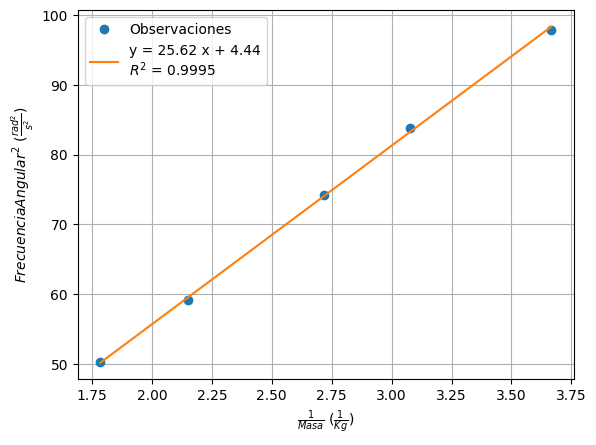

Valor de K = 25.61594505891568 +- 0.9523363481128863


In [17]:
a, b, da, db = fit_with_curve(lineal, df['1_M'], df['w2'], df['dw2'])

R2 = 1 - np.sum((lineal(df['1_M'], a, b) - df['w2'])**2) / np.sum((df['w2'] - np.mean(df['w2']))**2)

#plt.errorbar(df['1_M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['1_M'], df['w2'], 'o', label='Observaciones')

plt.plot(df['1_M'], lineal(df['1_M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(r'$\frac{1}{Masa}$ ($\frac{1}{Kg}$)')
plt.ylabel(r'${Frecuencia Angular^2}$ ($\frac{rad^2}{s^2}$)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
K = a
dK = da
print(f"Valor de K = {K} +- {dK}")


In [18]:
res, erroresRelativos1, erroresRelativos2 = mayorErrorRelativo(df, 'M', 'dM', '1_w2', 'd_1_w2')
print(erroresRelativos1)
print(erroresRelativos2)
print(res)

[5.184827549395422e-05, 4.3490176590598906e-05, 4.710756112839636e-05, 4.297378599054577e-05, 3.990626911819446e-05]
[0.005567769930602736, 0.0051526839436239445, 0.004845963092083706, 0.004327458881190622, 0.003989944219861396]
['1_w2', '1_w2', '1_w2', '1_w2', '1_w2']


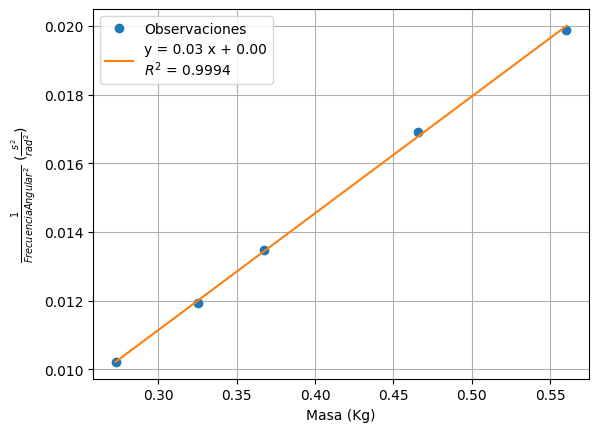

Valor de K = 29.388843922326267 +- 0.2618162091545926


In [19]:
a, b, da, db = fit_with_curve(lineal, df['M'], df['1_w2'], df['d_1_w2'])

R2 = 1 - np.sum((lineal(df['M'], a, b) - df['1_w2'])**2) / np.sum((df['1_w2'] - np.mean(df['1_w2']))**2)

#plt.errorbar(df['M'], df['L'], xerr=df['d_M'], yerr=df['dL'], fmt='o', label='Observaciones Con df')
plt.plot(df['M'], df['1_w2'], 'o', label='Observaciones')

plt.plot(df['M'], lineal(df['M'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(r'Masa (Kg)')
plt.ylabel(r'$\frac{1}{Frecuencia Angular^2}$ ($\frac{s^2}{rad^2}$)')
plt.legend()
plt.grid()
plt.show()

# calculemos K
K = 1/a
dK = 1/a**2 * da
print(f"Valor de K = {K} +- {dK}")


# Parte 2: Amortiguado

In [20]:
# Load all files in ./mediciones directory
mediciones = os.listdir('./mediciones/amortiguado')
files_amort = [f for f in mediciones if f.startswith('resortecalibrado')]
files_amort.sort()

# Load all files
dfs_amort = []
df = pd.DataFrame(columns=['M', 'L'])

for f in files_amort:
    # peso = pd.read_csv(f'./mediciones/amortiguado/{f}', sep=',', header=0, nrows=0).columns[1]
    # distancia = pd.read_csv(f'./mediciones/amortiguado/{f}', sep=',', header=1, nrows=0).columns[1]
    # temp_df = pd.DataFrame({'M': float(peso)/1000,
    #                              'L': float(distancia)/1000}, index=[0])
    # df = pd.concat([df, temp_df], ignore_index=True)

    dfs_amort.append(pd.read_csv(f'./mediciones/amortiguado/{f}', sep=',', header=0))



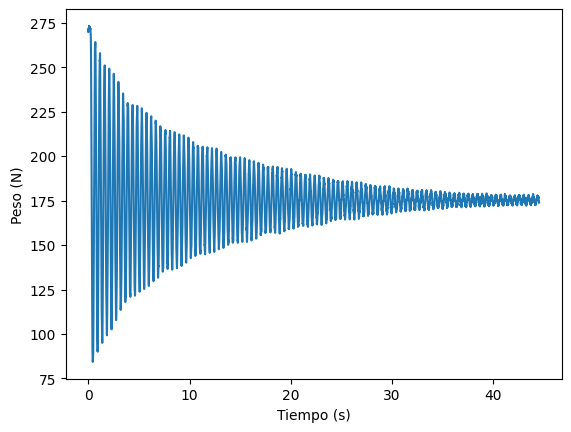

In [21]:
plt.plot(dfs_amort[0]['time'], dfs_amort[0]['(N)'])
plt.xlabel('Tiempo (s)')
plt.ylabel('Peso (N)')
plt.show()


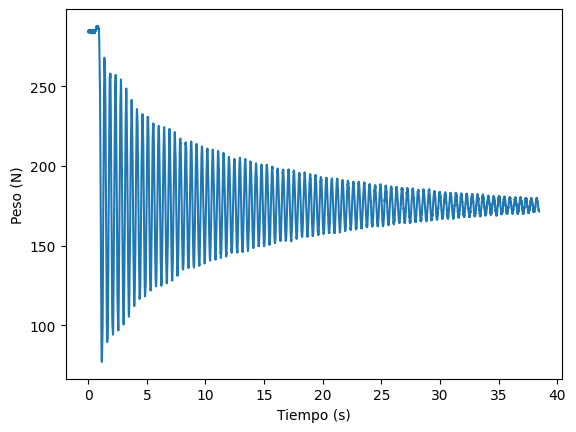

In [22]:
plt.plot(dfs_amort[1]['time'], dfs_amort[1]['(N)'])
plt.xlabel('Tiempo (s)')
plt.ylabel('Peso (N)')
plt.show()

In [23]:
dfs_amort[0]

,time,(N)
0,0.000,270.5855
1,0.005,269.6783
2,0.010,270.0574
3,0.015,270.2064
4,0.020,270.6532
...,...,...
8898,44.490,174.7893
8899,44.495,174.5997
8900,44.500,174.2341
8901,44.505,174.1935


In [24]:
dfs_amort[1]

,time,(N)
0,0.000,284.6672
1,0.005,284.3287
2,0.010,283.8548
3,0.015,284.0173
4,0.020,284.4370
...,...,...
7685,38.425,172.5687
7686,38.430,171.7834
7687,38.435,172.1219
7688,38.440,171.5667


In [48]:
# Plot dfs_amort[0] dataframe using plotly
import plotly.express as px

fig = px.line(dfs_amort[0], x='time', y='(N)', title='Peso vs Tiempo')

# Add a vertical line every 0.2 seconds
for i in range(0, 96):
    fig.add_vline(x=0.7 + i*44.37/96.5, line_color="red")

fig.show()


In [68]:
# Fit sin function to the data
from scipy.optimize import curve_fit

def Amp(A, lamb, t, F0):
    return A * np.exp(-lamb * t) + F0

def sin(x, A, lamb, F0, w, phi, C):
    return Amp(A, lamb, x, F0) * np.sin(w * x + phi) + C

# Fit the sin function to the data
popt, pcov = curve_fit(sin, dfs_amort[0]['time'], dfs_amort[0]['(N)'], p0=[1, 1, 0, 2*np.pi/0.5, 0, 0])

# Plot the data and the fit using plotly
x = np.linspace(0, 44.37, 10000)
y = sin(x, *popt)

fig = px.line(x=x, y=y, title='Fit sin function to the data')
# Add the data to the plot with pointy lines
fig.add_scatter(x=dfs_amort[0]['time'], y=dfs_amort[0]['(N)'], mode='markers', name="Mediciones", marker=dict(size=3))
fig.show()

print("A: ", popt[0])
print("lambda: ", popt[1])
print("F0: ", popt[2])
print("w: ", popt[3])
print("phi: ", popt[4])
print("C: ", popt[5])


A:  79.92225637431143
lambda:  0.07954491611476137
F0:  -1.570164069088338
w:  13.62345214878428
phi:  -1.4279583193283885
C:  175.74192638320537


In [54]:
popt


array([9.62521749e+01, 1.00000000e+00, 1.89008477e+02, 2.64738253e+00,
       1.26335282e+01, 4.03059177e-02, 1.75746040e+02])